### 基本信息

GoFun出行是首汽集团针对移动出行推出的一款新能源共享汽车产品，秉承首汽集团作为全国最大出行服务运营企业的多年经验和优势资源，响应政府号召，把握“新能源+车联网”的全趋势，致力于整合用户碎片化的用车需求，提供便捷、绿色、快速、经济的出行服务。 GoFun出行是共享行业新兴的一种租车模式，车辆无人值守，用车全程App操作，以“分钟+公里”计算并提供汽车的即取即用、分时租赁服务，消费者可按个人用车需求预订车辆。GoFun出行已相继完成全国20余个城市的布局，其中不乏北京、上海、武汉、成都、南京等一、二线城市，更有西安、青岛、昆明、桂林、三亚等重要旅游地。

对于共享汽车企业来讲，车辆信息是比较简单的基本信息，获取这些信息也相对简单。只需要抓取一天的数据即可得到。

In [1]:
%matplotlib inline

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
# 放大字体，易于阅读
sns.set(font="WenQuanYi Micro Hei", font_scale=1.5)
plt.style.use('fivethirtyeight')

def connect():
    return psycopg2.connect(
        database='gofun',
        user='derekhe',
        password='',
        host='localhost',
        port='5400')

# 保持一个数据库连接而不用每次都连接
conn = connect()

# 车牌号所对应的省份名称缩写
all_plates = [
    "京", "津", "沪", "冀", "豫", "云", "辽", "黑", "湘", "皖", "鲁", "新", "苏", "浙", "赣",
    "鄂", "桂", "甘", "晋", "蒙", "陕", "吉", "闽", "贵", "粤", "川", "青", "藏", "琼", "宁",
    "渝"
]

# 获取到数据库中所有的表
def get_all_tables():
    with connect() as cnx:
        with cnx.cursor() as cursor:
            cursor.execute(
                "SELECT tablename FROM pg_catalog.pg_tables WHERE tablename LIKE 'sharecar_%'")
            return [x[0] for x in cursor.fetchall()]
        
all_tables = get_all_tables()

在抓取到的数据中，我们可以分析出车的类型、车的品牌、座位数量、购车年代的分布情况，可以从整体上把握共享汽车厂商的投资的方向。得到这几个数据的方法比较类似。以车的类型为例。我们首先通过以下SQL语句从最后一天的数据中去掉重复的结果并放到临时表t中
```sql
SELECT
    plate_num,
    series
FROM sharecar_20180115
GROUP BY plate_num, series
```
然后再通过计算临时表t中的数据输出结果。

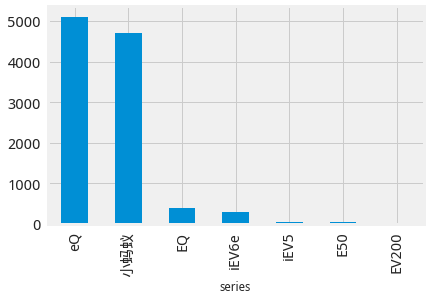

In [2]:
# 车类型
df = pd.read_sql("""
SELECT
  t.series,
  count(plate_num) AS count
FROM (SELECT
        plate_num,
        series
      FROM sharecar_20180115
      GROUP BY plate_num, series) AS t
GROUP BY series
ORDER BY count DESC;
""", conn)
df.plot.bar(x='series', legend=False)
df.to_json("./analysis/car_types.json", force_ascii=False, orient='records')

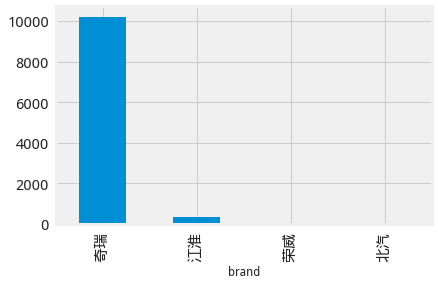

In [3]:
# 品牌类型
df = pd.read_sql(
"""
SELECT
  t.brand,
  count(plate_num) AS c
FROM (SELECT
        plate_num,
        brand
      FROM sharecar_20180115
      GROUP BY plate_num, brand) AS t
GROUP BY brand
ORDER BY c DESC
""",conn)
df.plot.bar(x='brand', legend=False)
df.to_json("./analysis/brands.json", force_ascii=False, orient='records')

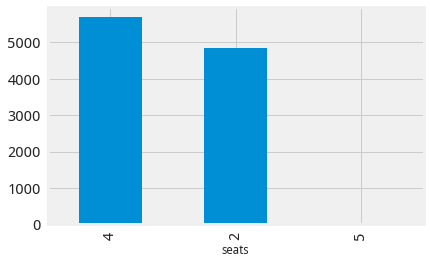

In [4]:
# 座位分布
df = pd.read_sql(
"""SELECT
  t.seats,
  count(plate_num) AS c
FROM (SELECT
        plate_num,
        seats
      FROM sharecar_20180115
      GROUP BY plate_num, seats) AS t
GROUP BY seats
ORDER BY c DESC
""",conn)
df.plot.bar(x='seats', legend=False)
df.to_json("./analysis/seats.json", force_ascii=False, orient='records')

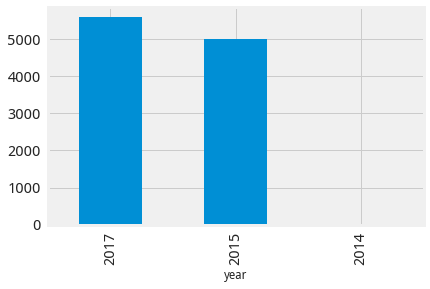

In [5]:
# 购车年代
df = pd.read_sql(
"""SELECT
  t.year,
  count(plate_num) AS c
FROM (SELECT
        plate_num,
        substring(year FROM 0 FOR 5) AS year
      FROM sharecar_20180115
      GROUP BY plate_num, year) AS t
GROUP BY year
ORDER BY c DESC""",conn)
df.plot.bar(x='year', legend=False)
df.to_json("./analysis/year.json", force_ascii=False, orient='records')

从上面几幅图可以知道，GoFun绝大多数车型都是奇瑞的车。两座和四座的车是主流，在网上查询以后得知这种车身小巧，一方面比较节能，另一方面比较容易操作。为什么是奇瑞的车占据绝大部分份额呢？从网络搜索到两条新闻可以知道奇瑞是GoFun的合作伙伴，这也不足为奇了：
* Gofun出行采购万辆奇瑞“小蚂蚁” 助力全国战略
* 大众和奇瑞超2亿入股GoFun

### 业务概况

通过对最后一天出现的独立的牌照号码的计算，可以得出车辆的数量情况。

In [6]:
# 车总数量
df = pd.read_sql("select distinct(plate_num) from sharecar_20180115;", conn)
len(df)

10593

然后我们考察车辆的增长情况。通过增长的情况可以看出运营的健康程度，是否在持续增长中，以及预测未来的趋势。在这里，我们选择每个月有2的那一天作为节点，看看每隔大约10天的增长情况。注意，车辆数量有时候会变少，这是因为数据采集时只能采集到没在使用的汽车，所以会少一些。整体趋势来讲呈平稳上升趋势，说明目前发展状况稳定。从结果中可以看到车的整体情况是在平稳增长的。

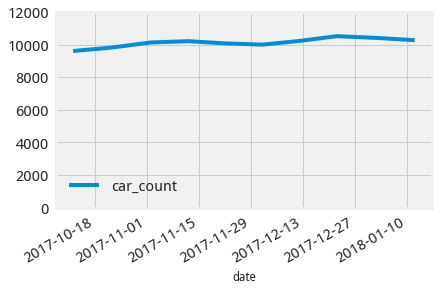

In [7]:
# 车数量增长
from datetime import datetime
parks = []
dates = []
for table in all_tables:
    if table[-1] == '2':
        df = pd.read_sql(
            "select count(distinct(plate_num)) from " + table, conn)
        parks.append(df['count'].values[0])
        dates.append(datetime.strptime(table[9:], "%Y%m%d"))
df = pd.DataFrame(parks, columns=['car_count'])
df['date'] = dates
df.set_index('date', inplace=True)
df.to_json("./analysis/car_increase.json", force_ascii=False, orient='records')
df.plot(ylim=(0, 12000))

再看看车辆的数量分布。按照GoFun所运行的城市来查询每个城市的车辆数量，可以看出来在四川、广东、陕西、福建等省有很多的车辆，属于比较正常的情况。上海的车辆数量很少，我猜测在上海早已有竞争对手占据了市场，还不如避而求其次。

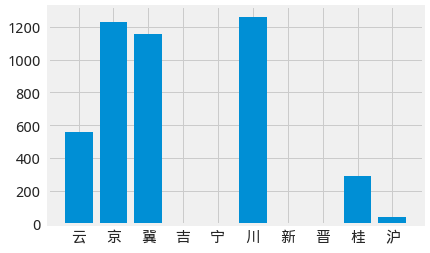

In [8]:
# 各省车辆分布
def search(prefix):
    df = pd.read_sql(
        "SELECT COUNT(DISTINCT(plate_num)) from sharecar_20180115 where plate_num like '%s%%'"
        % prefix, conn)
    return df['count'][0]


x = []
y = []
for city in all_plates:
    x.append(city)
    y.append(search(city))

plt.bar(x, y)
plt.show()

df_car = pd.DataFrame.from_records(
    list(zip(x, y)), columns=['province', 'count'])
df_car = df_car[df_car['count'] != 0]
df_car.to_json("./analysis/car_distrubution.json",
               force_ascii=False, orient='records')

下面开始分析停车场的信息。由于GoFun必须在指定地点借还，停车场的数量多少就直接影响到用户体验。随着车的增长，停车场的数量也应该有相应的增长才对。和车辆数量计算类似，得到parking_name的去重后出现的次数即可。从输出的图里面也看出停车场的增长较为平稳。

In [9]:
# 停车场总数量
df = pd.read_sql("select distinct(parking_name) from sharecar_20180115;", conn)
len(df)

2765

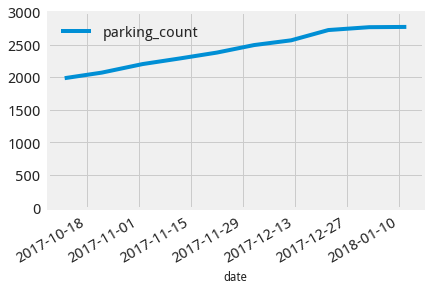

In [10]:
# 停车场数量增长
parks = []
dates = []

for table in all_tables:
    if table[-1] == '2':
        df = pd.read_sql(
            "select count(distinct(parking_name)) from " + table, conn)
        parks.append(df['count'].values[0])
        dates.append(datetime.strptime(table[9:], "%Y%m%d"))
        
df = pd.DataFrame(parks, columns=['parking_count'])
df['date'] = dates
df.set_index('date', inplace=True)
df.to_json("./analysis/parking_increase.json",
           force_ascii=False, orient='records')
df.plot( y='parking_count', ylim=(0, 3000))

然后转换到百度坐标系中以方便在地图和进行展示。数据会输出到json文件中待后续使用。

In [11]:
# 获得并转换所有停车场位置
import math

x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626  # π
a = 6378245.0  # 长半轴
ee = 0.00669342162296594323  # 偏心率平方


def gcj02_to_bd09(lng, lat):
    """
    火星坐标系(GCJ-02)转百度坐标系(BD-09)
    谷歌、高德——>百度
    :param lng:火星坐标经度
    :param lat:火星坐标纬度
    """
    z = math.sqrt(lng * lng + lat * lat) + 0.00002 * math.sin(lat * x_pi)
    theta = math.atan2(lat, lng) + 0.000003 * math.cos(lng * x_pi)
    bd_lng = z * math.cos(theta) + 0.0065
    bd_lat = z * math.sin(theta) + 0.006
    return [bd_lng, bd_lat]


# 获得所有停车场的位置。由于同一个停车场的位置的经纬度在不同时刻抓取可能有一些微小的偏差，所以拿到数据后再进行去重处理
df = pd.read_sql(
    "SELECT position[0] as lat, position[1] as lon, parking_name from sharecar_20180115", conn)
df = df.drop_duplicates(subset=['parking_name'])

# 转换到百度坐标系以便于后续在地图上展示
def convert(x):
    converted = gcj02_to_bd09(x[0], x[1])
    return converted[0], converted[1]


df['location'] = df.apply(convert, axis=1)

df.to_json("./analysis/park_locations.json",
           force_ascii=False, orient='records')

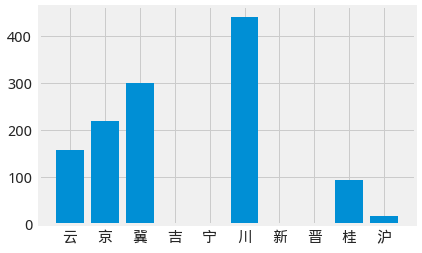

In [12]:
# 各省停车场分布
def search(prefix):
    df = pd.read_sql(
        "SELECT COUNT(DISTINCT(parking_name)) from sharecar_20180115 where plate_num like '%s%%'"
        % prefix, conn)
    return df['count'][0]


x = []
y = []
for city in all_plates:
    x.append(city)
    y.append(search(city))

plt.bar(x, y)
plt.show()

df_park = pd.DataFrame.from_records(
    list(zip(x, y)), columns=['province', 'count'])
df_park = df_park[df_park['count'] != 0]
df_park.to_json("./analysis/park_distrubution.json",
                force_ascii=False, orient='records')

我们再来看一下多少汽车共用一个停车场的情况，即停车场的容量。通过对车和停车场的进行简单的相除计算即可得到结果。从数据看出，平均来看大致一个停车场目前有3辆车的规模。如果一个停车场容纳的车越多，那么用户能够拿到车的几率越大，从这方面看也是一个好事。如果停车场的数量较少，网点不密集，就会影响用户的到达性。从数据可以看到出湖北省的比例最高，从之前的车辆数量排名看湖北省排名第5，但停车场数量排名第10，停车场数量偏少。

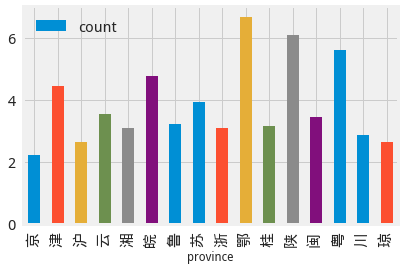

In [13]:
# 平均每停车场容量

df_average_cars_per_park = (df_car.set_index(
    "province") / df_park.set_index("province"))
df_average_cars_per_park['province'] = df_average_cars_per_park.index
df_average_cars_per_park.to_json(
    "./analysis/average_cars_per_park.json", force_ascii=False, orient='records')
df_average_cars_per_park.plot.bar(y='count')

接下来会研究运营中的车辆的使用情况。数据库中存储的是每个时刻点车辆的停车场、电量等信息，以一台车一天的轨迹为例，可以看到从凌晨到早上6：55都是停留在“御廷上郡东北门地面停车场（学苑路）”这个停车场，接下来11点12分，停留在了“环球中心E2地面停车场”。由于我们在使用中的车辆我们是获取不到任何信息的，所以可以断定在这段时间内车辆是在使用中。然后该车在“环球中心E2地面停车场”停到了12点37分，接下来又被使用，最终在19：59分，出现在“长江职业学院路边停车位“停车场。

|time|plate_num|position|battery|parking_name|
|--- |--- |--- |--- |--- |
|2018-01-15 00:02:40.000000|川A01J9M|(104.0931595,30.5514717)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 01:24:30.000000|川A01J9M|(104.0933585,30.5513664)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 03:56:05.000000|川A01J9M|(104.093156,30.5514503)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 03:05:38.000000|川A01J9M|(104.0935267,30.552023900000002)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 04:29:18.000000|川A01J9M|(104.093156,30.5514503)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 04:46:42.000000|川A01J9M|(104.093156,30.5514503)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 04:59:06.000000|川A01J9M|(104.093314,30.5513932)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 06:12:30.000000|川A01J9M|(104.093314,30.5513932)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 06:55:57.000000|川A01J9M|(104.0933503,30.5514796)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 11:12:39.000000|川A01J9M|(104.0662597,30.5691721)|81|环球中心E2地面停车场|
|2018-01-15 12:37:24.000000|川A01J9M|(104.0662715,30.569191)|81|环球中心E2地面停车场|
|2018-01-15 19:59:39.000000|川A01J9M|(104.1667665,30.6454576)|66|长江职业学院路边停车位*（规范停放）|


我们最终想要输出的结果是去除在同一个地方停留的重复数据，以便后续的继续分析。我们将每台车的信息都保存在一个json文件中，以方便后续的分析以及与HTML5页面的集成。另外，数据也不是必须要导出到json文件，也可以导出到CSV或者HDF5等格式进行存储。

|time|plate_num|position|battery|parking_name|
|--- |--- |--- |--- |--- |
|2018-01-15 00:02:40.000000|川A01J9M|(104.0931595,30.5514717)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 06:55:57.000000|川A01J9M|(104.0933503,30.5514796)|60|御廷上郡东北门地面停车场（学苑路）|
|2018-01-15 11:12:39.000000|川A01J9M|(104.0662597,30.5691721)|81|环球中心E2地面停车场|
|2018-01-15 12:37:24.000000|川A01J9M|(104.0662715,30.569191)|81|环球中心E2地面停车场|
|2018-01-15 19:59:39.000000|川A01J9M|(104.1667665,30.6454576)|66|长江职业学院路边停车位*（规范停放）|

In [16]:
import concurrent.futures
import os
import psycopg2
import pandas as pd


def dump_car_movement_details(plateNum, all_tables):
    with connect() as conn:
        filename = "./out/" + plateNum + ".json"
        if os.path.exists(filename):
            return

        sqls = []
        sql = ""
        for t in all_tables:
            sqls.append("""
                select time, parking_name, position, battery from %s where plate_num = '%s'
                """ % (t, plateNum))
        sql += "UNION ALL".join(sqls)

        df = pd.read_sql(
            sql, conn,
            index_col='time').sort_index().tz_convert("Asia/Shanghai")

        # 如果parking_name与上一行、下一行都是一致的，则认为是重复的，可以去掉
        df['duplicated'] = df['parking_name'].shift() == df['parking_name'].shift(-1)
        rst = df[df['duplicated'] != True].drop(columns=['duplicated'])

        rst.to_json(filename, force_ascii=False,
                    date_format='iso', orient='index')
        print(plateNum)

# 使用多进程进行处理，加速处理过程。需要注意的是如果数据库存放在机械硬盘中，多进程操作可能由于磁盘IO效率低下而没有作用甚至速度减慢。
# 所以建议将数据库放在SSD硬盘上以加速检索

executor = concurrent.futures.ProcessPoolExecutor()
df = pd.read_sql("select distinct(plate_num) from sharecar_20180115;", conn)
for p in df['plate_num'].values:
    executor.submit(dump_car_movement_details, p, all_tables)
executor.shutdown()

将每台车的信息存储到json文件后，后续的处理可以直接读取这些json文件进行处理，也可以用纯文本编辑器进行值的查看。
首先我们尝试获取一台车的使用频度。对于共享经济而言，共享的次数越频繁，产生的价值越大。基于上述导出的数据，我们检测有多少次车辆的移动即可得到数据。我们将数据按照牌照号码、移动的数量存储在usage这个dict中，方便后续使用。

In [17]:
# 获得一辆车对应的使用次数
import glob
import os.path

usage = {}
for file in glob.glob("./out/*.json"):
    key = os.path.basename(file).replace(".json", "")
    df = pd.read_json(file, orient='index')
    if len(df) == 0:
        usage[key] = 0
        continue
        
    # 由于之前导出的信息中已经将中间的重复数据去掉，通过检测当前行和下一行的数据可以计算出是否在停车中
    # 当值一样时，说明是在停车当中；当值不一样时，说明从A地开到了B地
    df['is_parking'] = df['parking_name'].shift() == df['parking_name']
    rst = df[df['is_parking'] != True].drop(columns=['is_parking'])
    usage[key] = len(rst)

下图是三个月内车的使用次数的直方图。横坐标是使用的次数，纵坐标是次数对应的车的数量。近似一个正态分布，大约70%的车都在24到72的区间。平均起来每天0.3次到1次左右。

array(['川A3R71N', '川AT27K1', '川A6A37Y', ..., '皖AD02106', '粤A3E5Z0',
       '皖AD09883'], dtype=object)

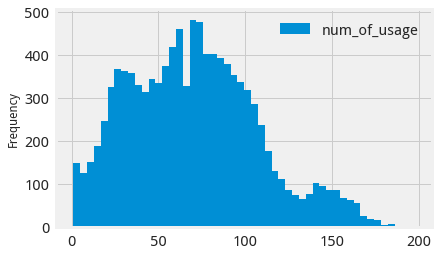

In [18]:
# 使用次数的直方图
import numpy as np
df = pd.DataFrame.from_dict(usage, orient='index')
df.columns = ['num_of_usage']
df.plot.hist(bins=50)

pd.Series(np.histogram(df, bins=50)).to_json(
    "./analysis/usage.json", force_ascii=False, orient='records')

# 输出按照使用次数得到的车辆排行
df.sort_values(by='num_of_usage', inplace=True, ascending=False)
plates = df.index.values
plates

但使用次数只是运营情况的一种体现。如果每次使用时间比较短，停车时间比较长，对GoFun也不是一个好事。下面一段代码导出每台车的起始信息，计算出是否是停驶，统计出使用和停车的时长的统计。

In [ ]:
# 停车和使用的时长数量统计
df_using = np.array([])
df_park = np.array([])


def calculate_detail(plate_num):
    global df_using
    global df_park

    df = pd.read_json("./out/" + plate_num + ".json", orient='index')
    if len(df) == 0:
        return df

    # pandas输出时会将时间转换成UTC，这里将时间转换成本地时间以方便查看
    df = df.tz_localize(
        "UTC").tz_convert("Asia/Shanghai").reset_index()

    # 取时间和停车场名字两列并计算时间差
    df = df[['index', 'parking_name', 'battery']]
    df['time_diff'] = (df['index'].shift(-1) - df['index']).fillna(0)
    df['is_parking'] = df['parking_name'] == df['parking_name'].shift(-1)

    # 将下一行的时间和地点的值往上移动，使得一行中包含起点和终点的信息
    df['start_time'] = df['index']
    df['end_time'] = df['index'].shift(-1)
    df['start_pos'] = df['parking_name']
    df['end_pos'] = df['parking_name'].shift(-1)
    df['start_battery'] = df['battery']
    df['end_battery'] = df['battery'].shift(-1)

    # 取需要的列并且丢弃掉最后一行
    df = df[['start_time', 'start_pos', 'start_battery', 'end_time', 'end_pos', 'end_battery', 'is_parking',
             'time_diff']][0:len(df) - 1]

    # 统计使用和在停车场的时长的数量
    df_using = np.append(df_using,
                         (df[df['is_parking'] == False]['time_diff'] / pd.Timedelta(hours=0.5)).values)
    df_park = np.append(df_park,
                        (df[df['is_parking'] == True]['time_diff'] / pd.Timedelta(hours=0.5)).values)

    return df


def dump_details(plate_num, filename):
    calculate_detail(plate_num).to_json(filename,
                                        force_ascii=False,
                                        date_format='iso',
                                        orient='records')


for p in plates:
    filename = "./detail/" + p + ".json"
    dump_details(p, filename)

下图展示了停车时长的分布。横坐标代表停车的时长（小时）最长统计到70小时，纵坐标代表有多少车次。从图上峰值是在0到2小时之间，有70000车次的数量。在横坐标末端连续70小的停车时长，也有1000多车次有过这样长的停车时间。

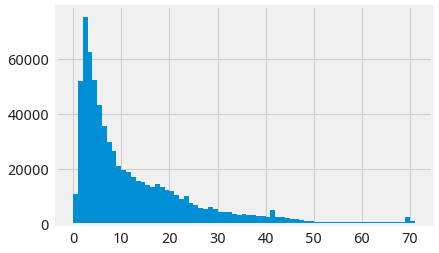

In [20]:
import matplotlib.pyplot as plt

bins = range(0, 72, 1)
plt.hist(df_using, bins=bins)
plt.show()

pd.Series(np.histogram(df_using, bins=bins)).to_json(
    "./analysis/using_hist.json", force_ascii=False, orient='records')

下图展示了使用时长的分布。横坐标代表停车的时长（小时）最长统计到70小时，纵坐标代表有多少车次。对比停车时长的分布，使用时长的分布比较明显的集中在0到6小时之间，这也是共享出行的特点。由于GoFun有包天的租车服务，所以长期的出行的费用也是可以接受，长达70小时以上的使用时间也有1700多车次。

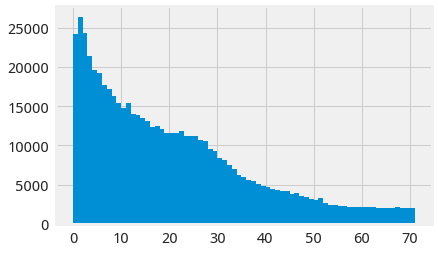

In [21]:
plt.hist(df_park, bins=bins)
plt.show()

pd.Series(np.histogram(df_park, bins=bins)).to_json(
    "./analysis/parking_hist.json", force_ascii=False, orient='records')

对于使用电池的共享汽车而言，电池电量的多少会影响出行的距离以及用户的使用感受。由于篇幅所限这里不做过多的研究，我们按照使用次数的排行选择三个车的电池的信息绘制出图，可以看到这几个车的电量几乎维持在40%以上的水平，最低点也在20%以上。说明大部分停车场的充电措施还是可以使用并且能够有效的在停车的时候做到及时充电。

根据电池的数据和车型，结合起始时间，还能够从另一个方面反映出车辆的行驶状况，更充分的分析运营情况。

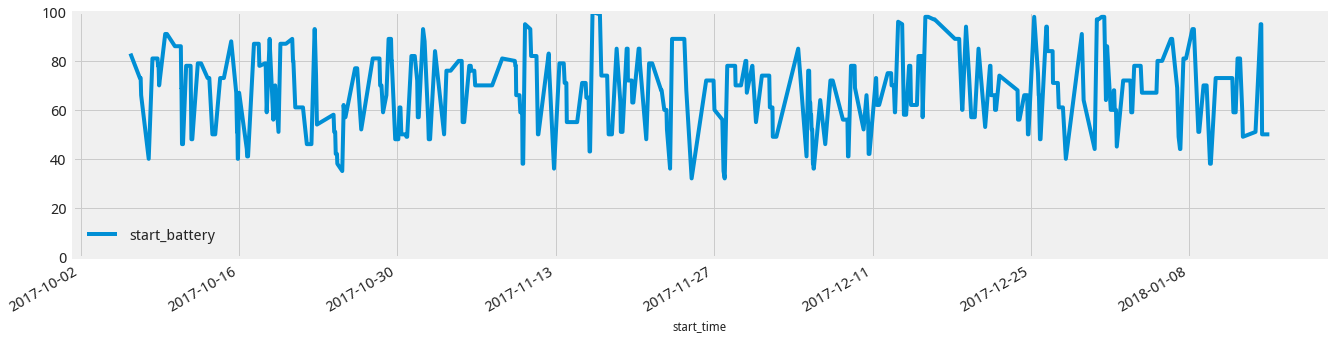

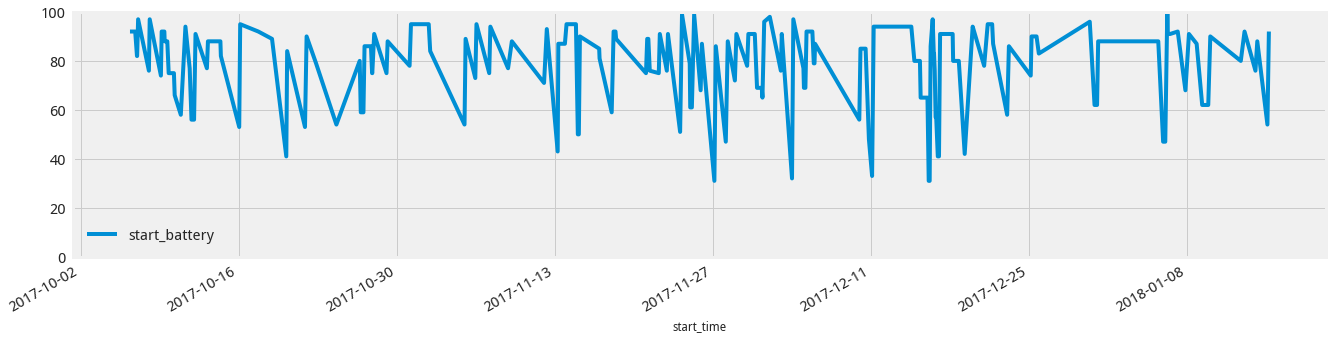

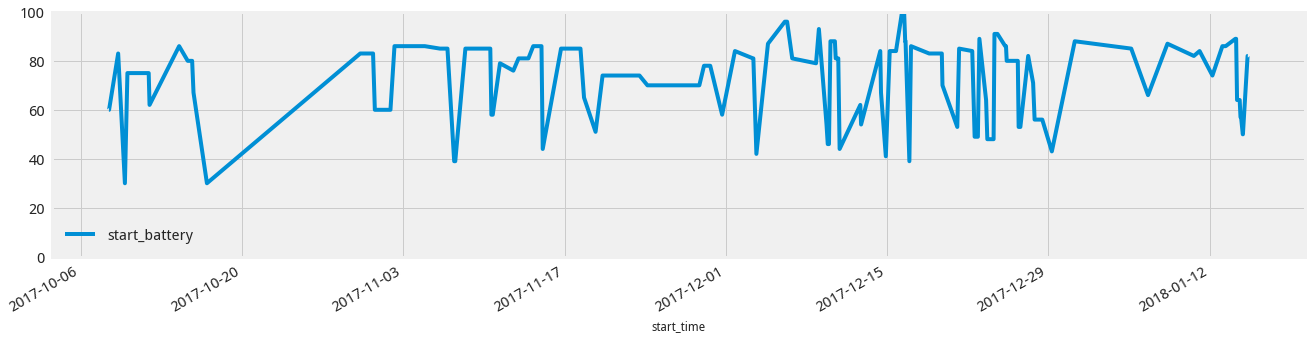

In [22]:
# 绘制电池
for i in range(1,9000,3000):
    plate = plates[i]
    df = pd.read_json("./detail/" + plate + ".json", orient='records').set_index('start_time')
    df = df.tz_localize("UTC").tz_convert("Asia/Shanghai").reset_index()
    figsize =  [20,5]
    df.plot(x='start_time', y='start_battery', figsize=figsize, ylim=(0,100))
    
    df.to_json("./analysis/battery_parking_" + plate +
               ".json", force_ascii=False, orient='records')